In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
import random
from scipy.ndimage import rotate, zoom
from sklearn.preprocessing import PowerTransformer
import pickle
from tqdm import tqdm
from multiprocessing import Pool
import gc

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from keras import models, layers, losses, optimizers, Model
from keras.utils import plot_model

2023-11-08 11:40:09.898128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-08 11:40:09.898203: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-08 11:40:09.898252: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gc.collect()

0

In [5]:
def pickle_pi_set(pi):
    pi_set = []
    mat_i = loadmat(f"mats/data-science-P{pi+1}.mat")
    coord_to_col = mat_i["meta"][0][0][8]
    data = mat_i["data"]
    info = mat_i["info"][0]

    yeojohnTr = PowerTransformer(standardize=True)
    
    for i in tqdm(range(359), desc=str(pi)):
        datum = data[i][0][0]

        scan = np.zeros((23, 61, 51))
        for x in range(51):
            for y in range(61):
                for z in range(23):
                    scan[z, y, x] = datum[coord_to_col[x, y, z] - 1]


        mask = scan != mode(scan.flat).mode

        scan[mask] = yeojohnTr.fit_transform(scan[mask].reshape((-1, 1))).reshape((-1, ))
        scan[scan == mode(scan.flat).mode] = scan.min()
        scan[scan < -3] = -3
        scan[scan > 3] = 3
        scan /= 3

        pi_set.append((scan, info[i][2][0]))

    with open(f"pickles/{pi}.pkl", "wb") as f:
        pickle.dump(pi_set, f)
        

In [6]:
def pickle_set():
    if not os.path.exists("pickles"):
        os.mkdir("pickles")
    Pool(processes=5).map(pickle_pi_set, range(9))

pickle_set()

8: 100%|██████████| 359/359 [02:20<00:00,  2.56it/s]


In [5]:
NUM_CLASSES = 60

pickles = [pickle.load(open(f"pickles/{i}.pkl", "rb")) for i in range(9)]
targets = set([pickles[0][i][1] for i in range(len(pickles[0]))])

targets = list(targets)[:NUM_CLASSES]
targets = {target: [[0 if i != j else 1 for i in range(NUM_CLASSES)]] for j, target in enumerate(targets)}

pickles = [item for sublist in pickles for item in sublist if item[1] in targets]
pickles = sorted(pickles, key=lambda x: x[1])

trains, tests = [pickles[i] for i in range(len(pickles)) if i % 6 != 0], [pickles[i] for i in range(len(pickles)) if i % 6 == 0]

train_x = np.array([train[0] for train in trains])
train_y = np.array([train[1] for train in trains])

test_x = [test[0] for test in tests]
test_y = [test[1] for test in tests]

print(len(pickles), len(train_x), len(train_y), len(test_x), len(test_y))

del pickles, trains, tests

3231 2692 2692 539 539


In [6]:
def get_sample(train=True):
    x, y = ((train_x, train_y) if train else (test_x, test_y))
    
    i = random.randint(0, len(x) - 1)

    scan, target = x[i], y[i]
    scan = np.pad(scan, ((0, 0), (2, 1), (7, 6)), constant_values=scan.min())
    
    # scan = rotate(scan, random.randint(-5, 5), axes=(0, 1), order=0, reshape=False, mode="constant", cval=-1, prefilter=False)
    # scan = rotate(scan, random.randint(-5, 5), axes=(1, 2), order=0, reshape=False, mode="constant", cval=-1, prefilter=False)
    # scan = rotate(scan, random.randint(-5, 5), axes=(2, 0), order=0, reshape=False, mode="constant", cval=-1, prefilter=False)

    scan = np.expand_dims(scan, -1)
    
    target = targets[target]

    return scan, target

In [7]:
%matplotlib widget

def plot_scan(scan, _3d=True):
    scan, target = scan
    scan = (scan - scan.min()) / (scan.max() - scan.min())
    
    voxels = scan[scan != scan.min()]
    indices = np.where(scan != scan.min())

    if _3d:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
        ax.set_xticks([]) or ax.set_yticks([]) or ax.set_zticks([])
        ax.set_title(target)
        ax.scatter(indices[0], indices[1], indices[2], c=voxels, alpha=voxels, cmap="twilight", s=30, marker="s")
        plt.setp(ax.spines.values(), color=(1, 1, 1))
        plt.show()

    w = 5
    fig, ax = plt.subplots(w, w, constrained_layout=True)
    fig.dpi = 100
    bg_color = (225 / 255, 216 / 255, 226 / 255)
    fig.set_facecolor(bg_color)

    for j in range(w * w):
        ax[(j - j % w) // w, j % w].imshow(scan[j % scan.shape[0]], vmin=0, vmax=1, cmap="twilight")
        ax[(j - j % w) // w, j % w].set_xticks([])
        ax[(j - j % w) // w, j % w].set_yticks([])
        plt.setp(ax[(j - j % w) // w, j % w].spines.values(), color=bg_color)

    plt.show()

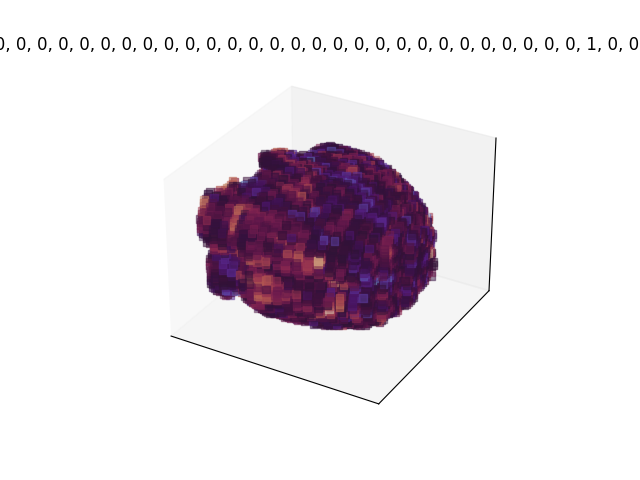

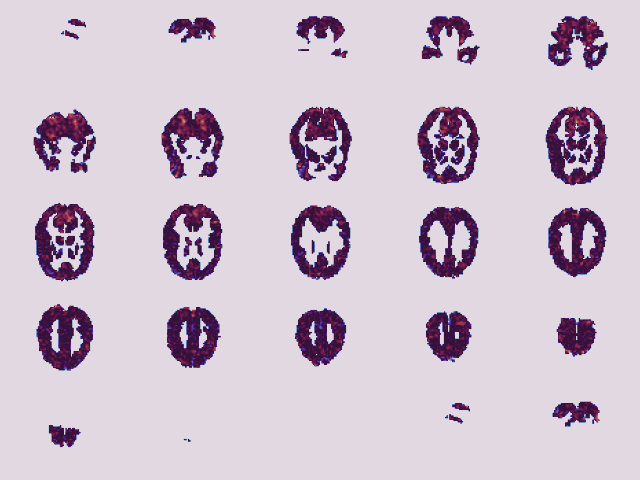

: 

In [8]:
plot_scan(get_sample())

In [11]:
def get_batch(batch_size=32, train=True):
    
    samples = list(Pool(processes=8).imap(get_sample, [train] * batch_size))
    batch_x = [sample[0] for sample in samples]
    batch_y = [sample[1] for sample in samples]

    return np.array(batch_x), np.array(batch_y)

In [23]:
class BasisSum(Model):
    def __init__(self):
        super().__init__()
        self.basis = tf.Variable(tf.ones((23, 61, 51, 25)))

    @tf.function(reduce_retracing=True)
    def call(self, x):
        return tf.matmul(self.basis, tf.reshape(x, (-1, 1, 1, 1, 25)), transpose_b=True)

In [ ]:
def layer_conv():
    return models.Sequential([
        layers.Input((64, 64 ,1)),
        layers.Conv2D(8, 16, 1, activation="tanh"),
        layers.Conv2D(8, 8, 1, activation="tanh"),
        layers.Conv2D(8, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(16, 8, 1, activation="tanh"),
        layers.Conv2D(32, 4, 1, activation="tanh"),
        layers.Conv2D(32, 2, 1, activation="tanh"),
        layers.Conv2D(64, 2, 1, activation="tanh"),
        layers.Conv2D(128, 2, 1, activation="tanh"),
        layers.Flatten()
    ])

class LayerwiseConv(Model):
    def __init__(self):
        super().__init__()
        self.convs = [layer_conv() for _ in range(23)]
        self.dense = models.Sequential([
            layers.Dense(512, activation="tanh"),
            layers.Dense(256, activation="tanh"),
            layers.Dense(128, activation="tanh"),
            layers.Dense(25, activation="tanh"),
        ])

    @tf.function(reduce_retracing=True)
    def call(self, x):
        conv_outputs = []
        for j, conv in enumerate(self.convs):
            conv_outputs.append(conv(x[:, j]))

        x = tf.convert_to_tensor(conv_outputs)
        x = tf.transpose(x, [1, 0, 2])
        x = tf.reshape(x, (-1, tf.reduce_prod(x.shape[1:])))
        x = self.dense(x)

        return x

In [ ]:
def conv3d_model():
    layers_ = [
               layers.ZeroPadding3D(((5, 4), (0, 0), (0, 0))),
               layers.Conv3D(8, 4, 1, padding="same", activation="tanh"),
               layers.Conv3D(8, 4, (1, 2, 2), padding="same", activation="tanh"),
               layers.Conv3D(16, 4, 2, padding="same", activation="tanh"),
               layers.Conv3D(16, 4, 1, padding="same", activation="tanh"),
               layers.Conv3D(32, 4, 2, padding="same", activation="tanh"),
               layers.Conv3D(32, 4, 1, padding="same", activation="tanh"),
               layers.Conv3D(64, 4, 2, padding="same", activation="tanh"),
               layers.Conv3D(64, 4, 1, padding="same", activation="tanh"),
               layers.Conv3D(128, 4, 1, padding="same", activation="tanh"),
               layers.Conv3D(128, 4, 2, padding="same", activation="tanh"),
               layers.Flatten(),
               layers.Dense(256, activation="tanh"),
               layers.Dense(128, activation="tanh"),
               layers.Dense(25, activation="tanh")
               ]
    
    inputs = layers.Input((23, 64, 64, 1))
    x = layers_[0](inputs)

    for layer in layers_[1:]:
        x = layer(x)
        x = layers.Dropout(0.8)(x)


    return Model(inputs=inputs, outputs=x)

In [ ]:
BATCH_SIZE = 64

model = conv3d_model()

opt = optimizers.Adam(learning_rate=0.0001)
loss = losses.CosineSimilarity()

def train():
    model.compile(opt, loss)

    for i in range(10000):
        with tf.GradientTape() as tape:
            batch_x, batch_y = get_batch(BATCH_SIZE)
            batch_x, batch_y = tf.convert_to_tensor(batch_x, dtype=tf.dtypes.float32), tf.convert_to_tensor(batch_y, dtype=tf.dtypes.float32)

            pred_y = model(batch_x)

            if i == 0:
                model.summary()

            batchloss = loss(batch_y, pred_y)
            grad = tape.gradient(batchloss, model.trainable_variables)
            opt.apply_gradients(zip(grad, model.trainable_variables))

            print(i, float(batchloss))

        if i % 100 == 0 and i != 0:
            batch_x, batch_y = get_batch(32, train=False)
            model.evaluate(batch_x, batch_y, batch_size=1)

            if i % 1000 == 0:
                model.save("model")

train()